<center><h1 style= "background-color: powderblue;"> MPEG-7 Classification Example using Deep Learning and Fine Tunning </h1></center>

In this page, we aim to classify the images from MPEG7 Shape database using neural network library Keras. The pre-trained model chosen for image classification is <b><i>InceptionV3</i></b> with weights trained on ImageNet.

<br>
The following steps are necessary to utilize this model in our application:
<ul>
    <li>Install Keras</li>
    <li>Download the weights files for the pre-trained network(s) (which we’ll be done automatically when you import and instantiate the respective network architecture).</li>
    <li>Train the model with smaller set on dataset images (<b>Fine Tunning</b>) </li>
    <li>Apply the pre-trained ImageNet networks from previous step to the images on database.</li>
</ul>

The MPEG-7 Shape dataset is avaliable in: http://www.dabi.temple.edu/~shape/MPEG7/dataset.html

## Setup Workspace
Set global options and import python packages

In [1]:
import sys
sys.path.append('../../')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from skimage.color import gray2rgb

import matplotlib.pyplot as plt

import sarpy as sp
from sarpy.datasets import load_mpeg7, mpeg7_get_class_name

import keras
import keras.applications.inception_v3 as inception
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K


Using TensorFlow backend.



## Data Loading, Normalization and Preprocessing
From our implemented library, it is possible to load the MPEG7 dataset images just calling the function <i>load_mpeg7</i>. As the images have distinct size, a normalization step is required in order to be processed by the keras InceptionV3 model.

In [2]:
# Loading dataset
dataset = load_mpeg7()
bitmaps, targets = dataset["bitmaps"], dataset["targets"]

number_of_classes = len(np.unique(targets))
print("Loaded dataset: {} examples, {} classes".format(len(bitmaps), number_of_classes))

# Normalizing images
image_size_height = image_size_width = 299
X = [image.img_to_array(gray2rgb(resize(bitmap.data, (299,299), mode="constant"))) for bitmap in bitmaps]
y = keras.utils.to_categorical(targets, num_classes=number_of_classes)

Loaded dataset. 1400 examples, 70 classes


<br>
As usual, the data is preprocessed splitting into training set and testing set.  

In [3]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state=42)
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)
print("Split X and Y into train (shapes: {},{}) and test (shape: {},{})".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Split X and Y into train (shapes: (700, 299, 299, 3),(700, 70)) and test (shape: (700, 299, 299, 3),(700, 70))


## Model Training [?]
<b>TODO</b>

In [4]:
# create the base pre-trained model, without top
base_model = inception.InceptionV3(weights='imagenet', include_top=False)

x = base_model.output

x = GlobalAveragePooling2D()(x)
# Fully-connected layer
x = Dense(1024, activation='relu')(x)
# Classes logistic layer -- with 70 classes
predictions = Dense(number_of_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# train the model on the new data for a few epochs
model.fit(X_train,y_train,batch_size=32, epochs=10);

Epoch 1/10
700/700 [==============================] - 340s - loss: 4.8138    
Epoch 2/10
700/700 [==============================] - 348s - loss: 2.7091    
Epoch 3/10
700/700 [==============================] - 345s - loss: 1.6734    
Epoch 4/10
700/700 [==============================] - 337s - loss: 0.9994    
Epoch 5/10
700/700 [==============================] - 345s - loss: 0.6902    
Epoch 6/10
700/700 [==============================] - 349s - loss: 0.5381    
Epoch 7/10
700/700 [==============================] - 363s - loss: 0.3436    
Epoch 8/10
700/700 [==============================] - 355s - loss: 0.3676    
Epoch 9/10
700/700 [==============================] - 320s - loss: 0.3140    
Epoch 10/10
700/700 [==============================] - 351s - loss: 0.1318    


In [5]:
# Evaluate the model
score = model.evaluate(X_test, y_test, batch_size=32)
print("Score:", score)

700/700 [==============================] - 361s    
Score: 1.47913465568


# Results
<b>TODO</b>: Say something cool~* about our results

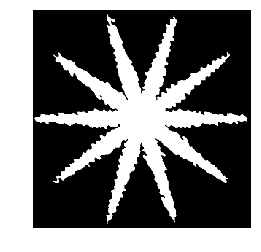

Predicted: device1 (True: device7)


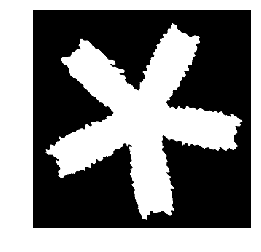

Predicted: device1 (True: device0)


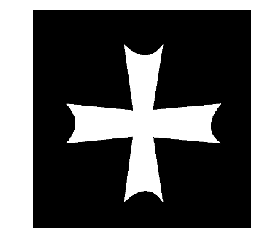

Predicted: device2 (True: device5)


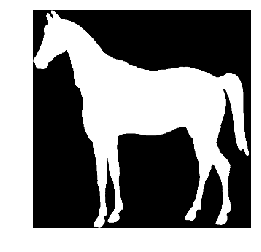

Predicted: horse (True: horse)


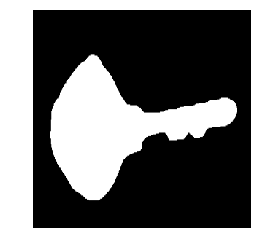

Predicted: guitar (True: key)


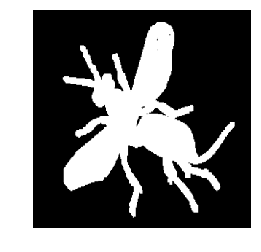

Predicted: octopus (True: fly)


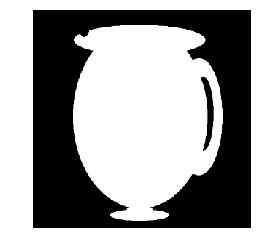

Predicted: jar (True: jar)


In [7]:
# Display some results
for test_image, test_target in zip(X_test[::int(len(X_test)/6)], y_test[::int(len(y_test)/6)]):
    # Predicting class
    predicted_class = model.predict(np.array([test_image]))[0]
    plt.imshow(test_image, cmap='gray')
    plt.axis('off')
    plt.show()
    print("Predicted: {} (True: {})".format(mpeg7_get_class_name(np.argmax(predicted_class)), mpeg7_get_class_name(np.argwhere(test_target)[0][0])))

# Tutorial Video 
Check our tutorial video below!

In [8]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/t2ByLmLnYJ8?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')
